## Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import torch

from tqdm.notebook import tqdm
from pandasql import sqldf
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertModel
# %load_ext autoreload
# %autoreload 2

## Read data

In [3]:
products_df = pd.read_parquet('data/products.parquet', engine='fastparquet')
reasons_df = pd.read_parquet('data/return_reasons.parquet', engine='fastparquet')
returns_df = pd.read_parquet('data/returns.parquet', engine='fastparquet')
reviews_df = pd.read_parquet('data/reviews.parquet', engine='fastparquet')

In [4]:
test_df = pd.read_parquet('data/test.parquet', engine='fastparquet')

In [7]:
reason_encoder = LabelEncoder()
returns_df['enc_cause'] = reason_encoder.fit_transform(returns_df.cause)
reason_encoder.classes_

array(['BAD_QUALITY', 'DEFECTED', 'PHOTO_MISMATCH', 'WRONG_ITEM',
       'WRONG_SIZE'], dtype=object)

In [6]:
test_df

,id,order_item_id,product_id,customer_id,purchase_price
0,3821007,25924705,c6e37feeae4ffb32c596278be5803dfbb2cae811a49f0a...,470a3be7a2064ccf6a2af3aa143422f8d73ac00ad8260e...,39000
1,3821335,26389794,104b05b6121c26b6376a7c78cfd904c33a5eea1107c71b...,91b874267fc80a4340b005cae70a9d7acd91e69dba7247...,87000
2,3821336,26389795,280443845f883cb83da5f4d5a6d838ed00ade8bd4b0685...,91b874267fc80a4340b005cae70a9d7acd91e69dba7247...,84000
3,3821337,26389792,84e5505da2298dafaeaafe7208cb51934c89bdac7dbae2...,91b874267fc80a4340b005cae70a9d7acd91e69dba7247...,158000
4,3821727,26549302,ddb80318c47647c6965ff30536323cfb2366ef63a4741b...,9862a7d705cf00508b564544b2ecd727c1d87b0cea704f...,239000
...,...,...,...,...,...
71318,4944490,32945249,28f308b5361d7c0541b968c6f33cbe2ef51807a0cb0517...,b3be073ac14ba8517def13c0d6ce21924056d3256ef242...,45000
71319,4944488,32945254,d881ec71ad01554482d1210524adbc44f4020cc4872b40...,b3be073ac14ba8517def13c0d6ce21924056d3256ef242...,299000
71320,4944483,32945257,a52f123e7042433c90a689ed331a513ffcade48c3dc9d9...,b3be073ac14ba8517def13c0d6ce21924056d3256ef242...,399000
71321,4944545,33387915,d46c762ca85d57ed59ba50af01eba5628f4233afffbf1c...,3f14748cfba77c742d3bd715397bd04228262ed6096e45...,420000


## Distribution of return reasons

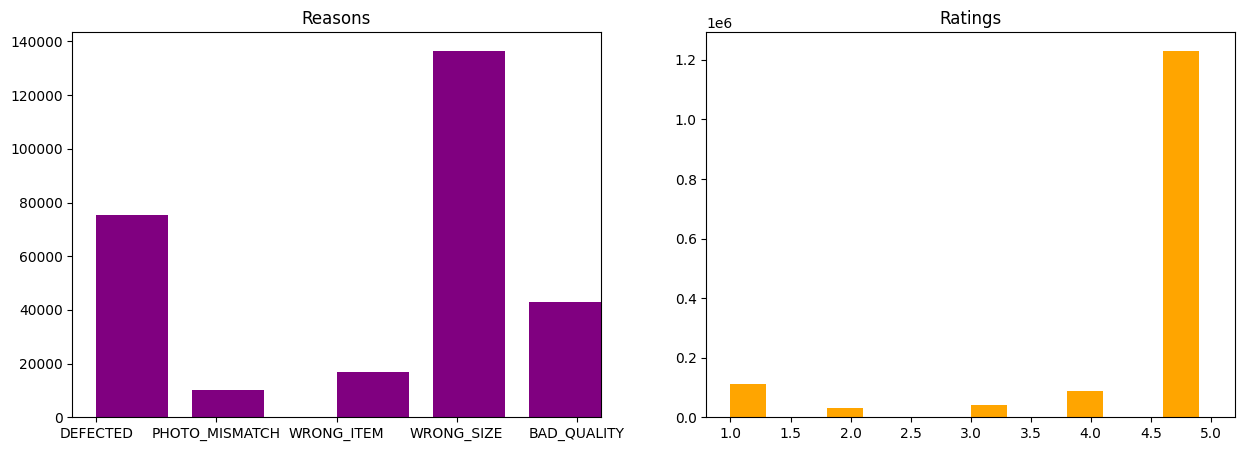

In [7]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 2, 1)
plt.hist(returns_df.cause, width=0.6, color='purple');
ax.set_title('Reasons')
ax = fig.add_subplot(1, 2, 2)
ax.set_title('Ratings')
plt.hist(reviews_df.rating, width=0.3, color='orange');

## Data of each customer average rating

In [8]:
customers_ratings = sqldf(
    '''
    SELECT customer_id,
           avg(rating )as customer_avg_rating
      FROM reviews_df
    GROUP BY customer_id
    '''
)

## Data of each product average rating

In [9]:
product_ratings = sqldf(
    '''
    SELECT product_id,
           avg(rating) as product_avg_rating
      FROM reviews_df
    GROUP BY product_id
    '''
)

## Apply M-BERT feature selection to reviews

In [10]:
# reviews = reviews_df['review_text']
# reviews = reviews.to_numpy()
# reviews

In [11]:
# model_name = 'bert-base-multilingual-cased'
# tokenizer = BertTokenizer.from_pretrained(model_name)
# model = BertModel.from_pretrained(model_name)

# cls_embeddings = []
# BATCH_SIZE = 1000


# for i in tqdm(range(0, len(reviews), BATCH_SIZE)):
#     batch_reviews = reviews[i:i+BATCH_SIZE]
#     enc_batch = tokenizer.batch_encode_plus(batch_reviews, return_tensors='pt', add_special_tokens=True, padding=True)
    
#     with torch.inference_mode():
#         output = model(**enc_batch)

#     cls_embeddings.append(output.pooler_output)

## Create train dataset to fit our model

In [12]:
train_df = sqldf(
    '''
    SELECT ret.id,
           ret.enc_cause as target,
           ret.purchase_price as price,
           cr.customer_avg_rating,
           pr.product_avg_rating
      FROM returns_df ret
      LEFT JOIN customers_ratings as cr 
        ON cr.customer_id = ret.customer_id
      LEFT JOIN product_ratings as pr 
        ON pr.product_id = ret.product_id
    '''
)

In [13]:
train_df.fillna(-1, inplace=True)
train_df.drop(columns='id', inplace=True)

In [14]:
train_df.to_csv('data/train_1.csv', index=False)

In [15]:
train_df

,target,price,customer_avg_rating,product_avg_rating
0,1,106000,-1.000000,4.000000
1,2,23000,-1.000000,4.776596
2,1,390000,1.000000,4.035714
3,3,71000,3.000000,1.000000
4,1,84000,4.333333,4.666667
...,...,...,...,...
282136,4,544000,4.619048,5.000000
282137,4,199000,4.619048,5.000000
282138,4,114000,3.000000,4.840909
282139,2,87000,-1.000000,4.750000


## Transform test dataset

In [16]:
test_df = test_df.drop(columns='id')

In [17]:
test_df = sqldf(
    '''
    SELECT t.purchase_price as price,
           cr.customer_avg_rating,
           pr.product_avg_rating
      FROM test_df t
    LEFT JOIN customers_ratings cr
    ON cr.customer_id = t.customer_id
    LEFT JOIN product_ratings pr
    ON pr.product_id = t.product_id
    '''
)

In [18]:
test_df.fillna(-1, inplace=True)

In [19]:
test_df.to_csv('data/test_1.csv', index=False)

In [29]:
mapping = dict(zip(reason_encoder.classes_, range(len(reason_encoder.classes_))))

In [30]:
mapping

{'BAD_QUALITY': 0,
 'DEFECTED': 1,
 'PHOTO_MISMATCH': 2,
 'WRONG_ITEM': 3,
 'WRONG_SIZE': 4}